<a href="https://colab.research.google.com/github/AndreyDyachkov/Data_analytics_with_Python_2/blob/main/Fuzzy_matching_algorithms_performance(confusion_matrix_stat_tests)/Fuzzy_matching_algorithms_performance(confusion_matrix_stat_tests).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative analysis of the performance of two fuzzy matching algorithms in recognition of healthcare facility names and addresses

### Goal

Compare the quality of string matching (clinic name and address) of two algorithms. The algorithm will be used in the task of clinic recognition in health insurance contract conditions and matching clinics with those in the local database.

### Methods

The test was carried out on 3 requests for proposal (RFP) in two stages.
  * First stage: the ML1 algorithm recognized the list of clinics in RFPs and found matches in the local database.
  * Second stage: The lists of clinics in RFPs were reduced to unique records (by fields: clinic name, clinic address) and recognized by the current MFLA method (similarity threshold 0.7).

Discrepancies in recognition between the first and second stages were checked manually. Recognition was analyzed by the fields: name of the clinic and address of the clinic. To evaluate the results, a confusion matrix was used:
* True positive (TP) -- the clinic is in the database and is recognized correctly.
* False positive (FP) -- the clinic is not in the  database and another clinic is selected or the clinic is in the database but was recognized incorrectly (another clinic was selected);
* True negative (TN) -- the clinic is not in the database and it is not recognized.
* False negative (FN) -- the clinic is in the database and it is not recognized.

Metrics:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)
* Accuracy = (TP + TN) / (TP + FP + TN + FN)
* F-score = 2 * ((Precision* Recall) / (Precision + Recall))

The z-test was used to search for statistically significant differences in precision, recall, and accuracy. The analysis was carried out on the sum of the results of three tenders.

### Results

Both models showed high efficiency, but the ML1 performs better:
* Precision: 97% vs 99% for MFLA and ML1, respectively. 2 p.p. difference is statistically significant (p<0.01)
* Recall: 64% vs 100% for MFLA and ML1, respectively. The difference is 36 p.p., statistically significant (p<0.01)
* Accuracy: 76% vs 99%, respectively. The difference is 23 p.p., statistically significant (p<0.01)
* F-score: 77% vs 99%, respectively.

### Analysis

#### Imports and data processing

In [ ]:
import pandas as pd
from scipy import stats as st

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data_analytics_with_Python_2/Fuzzy_matching_algorithms_performance(confusion_matrix_stat_tests)/data/fuzzy_matching_results_eng.xlsx')
df.head()

,test,algorithm,result,value
0,1,ML1,FN,3
1,1,ML1,FP,6
2,1,ML1,TN,549
3,1,ML1,TP,554
4,1,MFLA,FN,96


Combine the results of all tests

In [ ]:
df_grouped1 = df.groupby(['algorithm', 'result'], as_index=False)['value'].sum()
df_grouped1

,algorithm,result,value
0,MFLA,FN,483
1,MFLA,FP,27
2,MFLA,TN,747
3,MFLA,TP,859
4,ML1,FN,6
5,ML1,FP,17
6,ML1,TN,660
7,ML1,TP,1433


In [ ]:
df_pivoted1 =df_grouped1.pivot_table(index='algorithm', columns='result', aggfunc='sum', values='value')
#df_pivoted.columns = df_pivoted.columns.droplevel(0)
df_pivoted1.columns.name = None
df_pivoted1 = df_pivoted1.reset_index()
df_pivoted1.head()

,algorithm,FN,FP,TN,TP
0,MFLA,483,27,747,859
1,ML1,6,17,660,1433


#### Combined results for 3 RFP

In [ ]:
df_pivoted1['total'] = df_pivoted1[['FN', 'FP', 'TN', 'TP']].sum(axis=1)
df_pivoted1['precision'] = df_pivoted1['TP'] / (df_pivoted1['TP'] + df_pivoted1['FP'])
df_pivoted1['recall'] = df_pivoted1['TP'] / (df_pivoted1['TP'] + df_pivoted1['FN'])
df_pivoted1['accuracy'] = (df_pivoted1['TP'] + df_pivoted1['TN']) / df_pivoted1['total']
df_pivoted1['f_score'] = 2 * (df_pivoted1['precision'] * df_pivoted1['recall']) / (df_pivoted1['precision'] + df_pivoted1['recall'])
df_pivoted1

,algorithm,FN,FP,TN,TP,total,precision,recall,accuracy,f_score
0,MFLA,483,27,747,859,2116,0.969526,0.640089,0.758979,0.771095
1,ML1,6,17,660,1433,2116,0.988276,0.995830,0.989130,0.992039


In [ ]:
df_transposed = df_pivoted1[['algorithm','precision','recall','accuracy','f_score']].set_index('algorithm').transpose()
df_transposed['diff_pp'] = df_transposed['ML1'] - df_transposed['MFLA']
df_transposed.round(2)

algorithm,MFLA,ML1,diff_pp
precision,0.97,0.99,0.02
recall,0.64,1.00,0.36
accuracy,0.76,0.99,0.23
f_score,0.77,0.99,0.22


Since precision, recall, accuracy are ratios we can run z-test to test the significance of the differences

#### Precision

In [ ]:
n_ml = df_pivoted1['TP'][0] + df_pivoted1['FP'][0]
n_psb = df_pivoted1['TP'][1] + df_pivoted1['FP'][1]
p_ml = df_pivoted1['precision'][0]
p_psb = df_pivoted1['precision'][1]
p = (p_ml*n_ml + p_psb*n_psb) / (n_ml + n_psb)

In [ ]:
z = (p_ml - p_psb) / (p*(1-p)*(1/n_ml+1/n_psb))**(1/2)
alpha = 0.05
p_value = (1-st.norm.cdf(abs(z)))*2

print('z_value:', round(z,4))
print('p-value: ', round(p_value,4))
print('difference:',round(p_ml-p_psb,2))
if p_value <= alpha:
    print('reject H0')
else:
    print('no significant difference (H0 is true)')

z_value: -3.2345
p-value:  0.0012
difference: -0.02
reject H0


#### Recall

In [ ]:
n_ml = df_pivoted1['TP'][0] + df_pivoted1['FN'][0]
n_psb = df_pivoted1['TP'][1] + df_pivoted1['FN'][1]
p_ml = df_pivoted1['recall'][0]
p_psb = df_pivoted1['recall'][1]
p = (p_ml*n_ml + p_psb*n_psb) / (n_ml + n_psb)

In [ ]:
z = (p_ml - p_psb) / (p*(1-p)*(1/n_ml+1/n_psb))**(1/2)
alpha = 0.05
p_value = (1-st.norm.cdf(abs(z)))*2

print('z_value:', round(z,4))
print('p-value: ', round(p_value,4))
print('difference:',round(p_ml-p_psb,2))
if p_value <= alpha:
    print('reject H0')
else:
    print('no significant difference (H0 is true)')

z_value: -24.6252
p-value:  0.0
difference: -0.36
reject H0


#### Accuracy

In [ ]:
n_ml = df_pivoted1['total'][0]
n_psb = df_pivoted1['total'][1]
p_ml = df_pivoted1['accuracy'][0]
p_psb = df_pivoted1['accuracy'][1]
p = (p_ml*n_ml + p_psb*n_psb) / (n_ml + n_psb)

In [ ]:
z = (p_ml - p_psb) / (p*(1-p)*(1/n_ml+1/n_psb))**(1/2)
alpha = 0.05
p_value = (1-st.norm.cdf(abs(z)))*2

print('z_value:', round(z,4))
print('p-value: ', round(p_value,4))
print('difference:',round(p_ml-p_psb,2))
if p_value <= alpha:
    print('reject H0')
else:
    print('no significant difference (H0 is true)')

z_value: -22.563
p-value:  0.0
difference: -0.23
reject H0


#### F-score

In [ ]:
p_ml = df_pivoted1['f_score'][0]
p_psb = df_pivoted1['f_score'][1]
print('difference:',round(p_ml-p_psb,2))

difference: -0.22


### Additional analysis: dependence of precision, recall on the similarity threshold parameter in MFLA.

##### Methods

The same as in the main analysis + results for different similarity thresholds were added. The algorithm uses Jaccard similarity.

##### Results

The precision and recall measures intersect at the similarity threshold of 0.56. Accuracy, F-score have maximum values at similarity threshold values of 0.6.

##### Conclusion and reccomendations

For MFLA + manual check it is better to use a threshold of 0.5. Erroneously matched clinics can be deleted manually.
<br>
For a quick assessment of the number of clinics (which are in the database / not in the database) use a threshold of 0.6

##### Imports and data processing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_lookup = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data_analytics_with_Python_2/Fuzzy_matching_algorithms_performance(confusion_matrix_stat_tests)/data/fuzzy_lookup_tests.xlsx')
df_lookup.head()

,test,similarity,outcome,value
0,1,0.5,FN,1
1,1,0.5,FP,310
2,1,0.5,TN,248
3,1,0.5,TP,553
4,1,0.6,FN,28


In [ ]:
df_grouped2 = df_lookup.groupby(['similarity', 'outcome'], as_index=False)['value'].sum()
df_grouped2.head()

,similarity,outcome,value
0,0.5,FN,128
1,0.5,FP,402
2,0.5,TN,372
3,0.5,TP,1214
4,0.6,FN,277


In [ ]:
df_pivoted2 =df_grouped2.pivot_table(index='similarity', columns='outcome', aggfunc='sum', values='value')
#df_pivoted.columns = df_pivoted.columns.droplevel(0)
df_pivoted2.columns.name = None
df_pivoted2 = df_pivoted2.reset_index()
df_pivoted2.head()

,similarity,FN,FP,TN,TP
0,0.5,128,402,372,1214
1,0.6,277,129,645,1065
2,0.7,483,27,747,859


##### Summary metrics for different similarity thresholds

In [ ]:
df_pivoted2['total'] = df_pivoted2[['FN', 'FP', 'TN', 'TP']].sum(axis=1)
df_pivoted2['precision'] = df_pivoted2['TP'] / (df_pivoted2['TP'] + df_pivoted2['FP'])
df_pivoted2['recall'] = df_pivoted2['TP'] / (df_pivoted2['TP'] + df_pivoted2['FN'])
df_pivoted2['accuracy'] = (df_pivoted2['TP'] + df_pivoted2['TN']) / df_pivoted2['total']
df_pivoted2['f_score'] = 2 * (df_pivoted2['precision'] * df_pivoted2['recall']) / (df_pivoted2['precision'] + df_pivoted2['recall'])
df_pivoted2

,similarity,FN,FP,TN,TP,total,precision,recall,accuracy,f_score
0,0.5,128,402,372,1214,2116,0.751238,0.904620,0.749527,0.820825
1,0.6,277,129,645,1065,2116,0.891960,0.793592,0.808129,0.839905
2,0.7,483,27,747,859,2116,0.969526,0.640089,0.758979,0.771095


##### Dependence of precision, recall metrics on similarity threshold

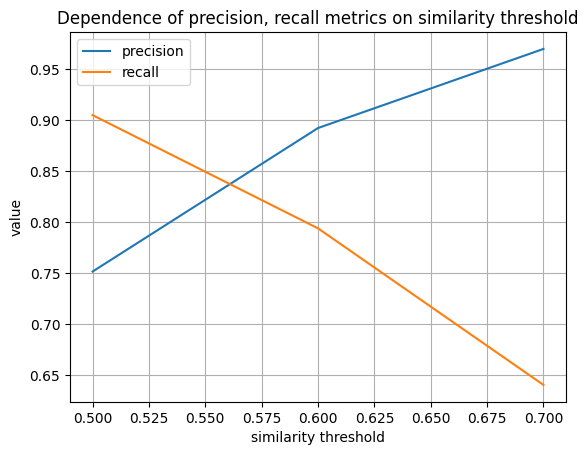

In [ ]:
x = df_pivoted2['similarity']
y1 = df_pivoted2['precision']
y2 = df_pivoted2['recall']

plt.plot(x, y1, label='precision' )
plt.plot(x, y2, label='recall')
plt.title('Dependence of precision, recall metrics on similarity threshold')
plt.legend()
plt.xlabel('similarity threshold')
plt.ylabel('value')
plt.grid()
plt.show()

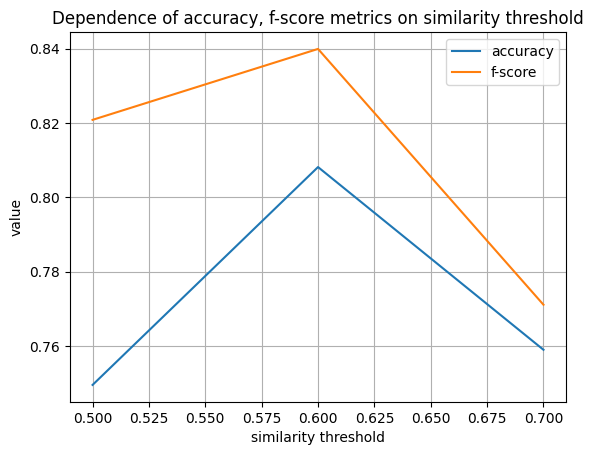

In [ ]:
x = df_pivoted2['similarity']
y1 = df_pivoted2['accuracy']
y2 = df_pivoted2['f_score']

plt.plot(x, y1, label='accuracy' )
plt.plot(x, y2, label='f-score')
plt.legend()
plt.title('Dependence of accuracy, f-score metrics on similarity threshold')
plt.xlabel('similarity threshold')
plt.ylabel('value')
plt.grid()
plt.show()